In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader

import torchvision
from torchvision import utils
from torchvision import models
from torchvision import datasets
from torchvision import transforms

from torchsummary import summary
from sklearn.model_selection import StratifiedShuffleSplit

import os
import copy
import yaml
import collections
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.STL10('./data', split='train', download=True, transform=transform)

train_ds.data.shape


Files already downloaded and verified


(5000, 3, 96, 96)

In [4]:
labels = [labels for _, labels in train_ds]
labels_counter = collections.Counter(labels)
labels_counter

Counter({1: 500,
         5: 500,
         6: 500,
         3: 500,
         9: 500,
         7: 500,
         4: 500,
         8: 500,
         0: 500,
         2: 500})

In [5]:
test_ds = datasets.STL10('./data', split='test', download=True, transform=transform)
test_ds.data.shape

Files already downloaded and verified


(8000, 3, 96, 96)

In [6]:
labels_t = [labels for _, labels in test_ds]
labels_t_counter = collections.Counter(labels)
labels_t_counter

Counter({1: 500,
         5: 500,
         6: 500,
         3: 500,
         9: 500,
         7: 500,
         4: 500,
         8: 500,
         0: 500,
         2: 500})

In [7]:
shuffle = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)
indicies = list(range(len(test_ds)))

# unpack generator
test_i, val_i = shuffle.split(indicies, labels_t).__next__()
print(test_i, test_i.shape)
print(val_i, val_i.shape)

[2096 4321 2767 ... 3206 3910 2902] (6400,)
[6332 6852 1532 ... 5766 4469 1011] (1600,)


In [8]:
val_ds = Subset(test_ds, val_i)
test_ds = Subset(test_ds, test_i)

print(len(val_ds))
print(len(test_ds))

1600
6400


In [9]:
val_labels = [label for _, label in val_ds]
test_labels = [label for _, label in test_ds]

val_counter = collections.Counter(val_labels)
test_counter = collections.Counter(test_labels)

print(val_counter)
print(test_counter)

Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})
Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})


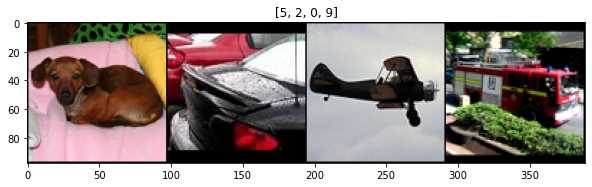

In [10]:
def show(img, label=None):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    if label is not None:
        plt.title(label)

img_idx = np.random.randint(0, len(train_ds), 4)

img_X = [train_ds[i][0] for i in img_idx]
img_y = [train_ds[i][1] for i in img_idx]
grid = utils.make_grid(img_X, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid, img_y)

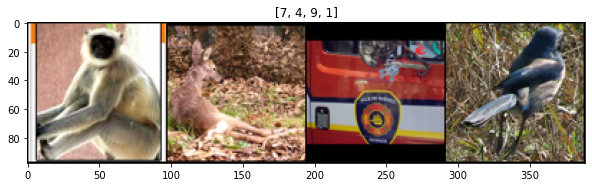

In [11]:
img_idx_v = np.random.randint(0, len(val_ds), 4)

img_X_v = [val_ds[i][0] for i in img_idx_v]
img_y_v = [val_ds[i][1] for i in img_idx_v]
grid_v = utils.make_grid(img_X_v, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid_v, img_y_v)

In [12]:
# mean and standard deviation
mean_rgb = [np.mean(img.numpy(), axis=(1, 2)) for img, _ in train_ds]
std_rgb = [np.std(img.numpy(), axis=(1, 2)) for img, _ in train_ds]

mean_r, mean_g, mean_b = [np.mean([m[i] for m in mean_rgb]) for i in range(3)]
std_r, std_g, std_b = [np.mean([s[i] for s in std_rgb]) for i in range(3)]

In [13]:
print(f'Mean - R: {mean_r:.4f} G: {mean_g:.4f} B: {mean_b:.4f}')
print(f'StdDev - R: {std_r:.4f} G: {std_g:.4f} B: {std_b:.4f}')

Mean - R: 0.4467 G: 0.4398 B: 0.4066
StdDev - R: 0.2241 G: 0.2215 B: 0.2239


In [14]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
    , transforms.RandomVerticalFlip(p=0.5)
    , transforms.ToTensor()
    , transforms.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
train_ds.transform = train_transform
test_ds.transform = test_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


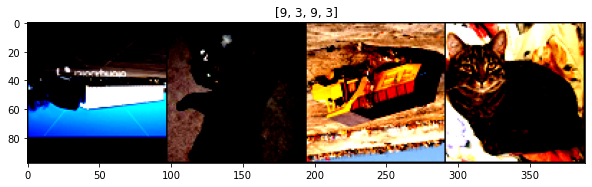

In [16]:
img_idx_n = np.random.randint(0, len(train_ds), 4)

img_X_n = [train_ds[i][0] for i in img_idx_n]
img_y_n = [train_ds[i][1] for i in img_idx_n]
grid_n = utils.make_grid(img_X_n, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid_n, img_y_n)

In [17]:
batch_size = hp['batch_size']

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

for data, _ in train_dl:
    print(data.shape) # batch size, channels, height, width
    break

torch.Size([64, 3, 96, 96])


In [18]:
net = models.resnet18(pretrained=False).cuda()
print(summary(net, input_size=(3, 96, 96)))

num_classes = hp['num_classes']
in_ftrs = net.fc.in_features
net.fc = nn.Linear(in_ftrs, num_classes)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [28]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0.00001)

In [29]:
def batch_accuracy(output: torch.Tensor, target: torch.Tensor):
    prediction = output.argmax(dim=1, keepdim=True)
    correct = prediction.eq(target.view_as(prediction)).sum().item()
    return correct

epoch 0, lr: 7.7e-05
epoch 1, lr: 3.3e-05
epoch 2, lr: 1.0e-05
epoch 3, lr: 3.2e-05
epoch 4, lr: 7.8e-05
epoch 5, lr: 1.0e-04
epoch 6, lr: 7.8e-05
epoch 7, lr: 3.3e-05
epoch 8, lr: 1.0e-05
epoch 9, lr: 3.2e-05


C:\Users\Bill\anaconda3\envs\DeepLearning\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
def batch_loss(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    with torch.no_grad():
        accuracy = batch_accuracy(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), accuracy

In [ ]:
def epoch_loss(net, criterion, dataset, optimizer=None):
    total_loss = 0.
    total_acc = 0.

    for data, target in dataset:
        data = data.cuda()
        target = target.cuda()

        output = net(data)
        # target = target.float().unsqueeze(1)
        loss, acc = batch_loss(criterion, output, target, optimizer)
        total_loss += loss

        if acc is not None:
            total_acc += acc

    loss = total_loss / float(len(dataset.dataset))
    acc = total_acc / float(len(dataset.dataset))

    return loss, acc

In [ ]:
params = {
    'epochs': hp['epochs'],
    'criterion': criterion,
    'optimizer': optimizer,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'scheduler': scheduler,
    'save_loc': './models/weights.pt',
}

history = {
    'train': {
        'loss': [],
        'acc': []
    },
    'val': {
        'loss': [],
        'acc': []
    }
}

def train(net, params):
    epochs = params['epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    scheduler = params['scheduler']
    save_loc = params['save_loc']
    weights = copy.deepcopy(net.state_dict())
    best_loss = float('inf')

    # train loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f'Train Epoch: {epoch + 1}/{epochs}\tLR: {lr}')

        # train
        net.train()
        loss_t, acc_t = epoch_loss(net, criterion, train_dl, optimizer)
        history['train']['loss'].append(loss_t)
        history['train']['acc'].append(acc_t)

        # eval
        net.eval()
        with torch.no_grad():
            loss_v, acc_v = epoch_loss(net, criterion, val_dl)
        history['val']['loss'].append(loss_v)
        history['val']['acc'].append(acc_v)

        if loss_v < best_loss:
            best_loss = loss_v
            weights = copy.deepcopy(net.state_dict())
            torch.save(weights, save_loc)
            print(f'Weights saved. Loss: {best_loss:.3f}')

        scheduler.step(loss_v)
        if lr != optimizer.param_groups[0]['lr']:
            net.load_state_dict(weights)
            print("Weights being loaded ...")

        print(f'Train loss: {loss_t:.3f}{" " * 5}Val loss: {loss_v:.3f}{" " * 5}Val acc: {acc_v * 100:.3f}')
        print('-' * 15)

    net.load_state_dict(weights)

    return net # trained model
